# Import packages

In [1]:
using PyPlot
using MathProgBase
using ReverseDiffSource

# Problem 1

In this problem, we classify sequences by their rates of convergence. 

### Solution

a) $x_k = \frac{1}{k}$. The limit of this sequence is 0. We compute its rate of convergence by the definition:

$$ \frac{\| x_{k+1} - x^* \|}{\| x_k - x^* \|} = \gamma$$ 

We obtain $\gamma = 1$ for our specific sequence as follows:

$$\frac{\| \frac{1}{k+1} \|}{\| \frac{1}{k} \| } = \frac{k}{k+1} \rightarrow 1$$

We conclude that our sequence converges sublinearly.

b) $x_k = 1 + 2^{-2^k}$. Following the same process, we find that with $q=1$, our sequence converges to 0. Increasing $q$ to 2, we obtain a $\gamma$ of 1 like so:

$$ \frac{\| (1+2^{-2^{k+1}}) - 1 \|}{ \|(1+2^{-2^k}) -1\|^2} = \frac{(2^{2^k})^2}{2^{2^{k+1}}}$$

$$= \frac{2^{2^{k+1}}}{2^{2^{k+1}}} \rightarrow 1$$

This sequence converges quadratically.

c) $x_k = 1+k^{-k}$. Choosing $q=1$, we obtain that $\gamma =0$:

$$\frac{(k+1)^{-(k+1)}}{k^{-k}} = \frac{k^k}{(k+1)^k} \frac{1}{k+1} \rightarrow 0$$.

But choosing $q = 2$, we obtain $\gamma = \infty$:

$$\frac{(k+1)^{-(k+1)}}{k^{-2k}} = \frac{k^{2k}}{(k+1)^{k+1}} \rightarrow \infty$$

Therefore, this sequence is superlinear, but not quite quadratic. Or maybe it can be considered quadratic, but with an infinite coefficient.


d) $x_k = \frac{1}{k!}$. With $q=1$, we get $\gamma = 0$:

$$\frac{\frac{1}{(k+1)k!}}{\frac{1}{k!}} = \frac{1}{k+1} \rightarrow 0$$

With $q=2$, $\gamma$ goes off to infinity though. Thus, this sequence is superlinear, but quite quadratic.

e) $x_k = $ \begin{cases} (1/4)^{2^k} & \mbox{if } k \mbox{ is even} \\ x_{k-1}/k & \mbox{ otherwise} \end{cases}. This sequence is clearly superlinear:

$$\frac{4^{2^{k}}}{4^{2^{k}}} \frac{1}{k} = \frac{1}{k} \rightarrow 0$$

However, if we choose $q=2$, the limit explodes. Therefore, it is quadratic.


# Problem 2

# Problem 3

## Newton's method

In [2]:
function newtonMethod(obj, x0; maxIts = 500, optTol = 1.0e-8, verbose=false)
    its = 0
    x = x0
    fvals = []
    gnormvals = []
    (f,g,H) = obj(x)
    g0 = g
    
    while (its < maxIts && norm(g,2) > optTol && norm(g,2) > (1.0e-4*norm(g0,2)))
        (f,g,H) = obj(x)
        d = -inv(H)*g;
        
        # Backtracking linesearch
        alpha = 1;
        mu = 10^-2.0;
        (newf,newg,newH) = obj(x+alpha*d);
        while newf > f + (alpha*mu)*(dot(g,d))
            (newf, newg, newH) = obj(x + alpha*d);
            alpha = alpha/2;
        end
        
        x = x + alpha * d
        
        its += 1
        fvals = [fvals; f]
        gnormvals = [gnormvals; norm(g,2)]
    end
    
    return (x,f,norm(g,2),its)
end

Qt: Untested Windows version 10.0 detected!


newtonMethod (generic function with 1 method)

In [3]:
# Now we apply it to the function f(x) = ||Ax||^2
A = 10*rand(3,3)

function obj(x)
    return (norm(A*x,2), 2*eye(3).*diag(A' * A) * x, 2*eye(3).*diag(A'*A)) 
end

newtonMethod(obj,[5,5,10])

([0.0,0.0,0.0],0.0,0.0,3)

# Problem 4

## Get data

In [4]:
# Get the data
data = readdlm("binary.csv",',','\r');
# Separate the independent var
y = data[2:end-1 , 1];
# Separate the dependent vars
u = data[2:end-1 , 2:4];
# Pad with 1's for \beta
o = ones(size(u,1));
u = [u o];
m = size(y,1);
n = 4;

## Define likelihood

In [5]:
# Define the likelihood function
expr = :(valL = 0;
    for i=1:m
        valL = valL - (y[i]*(a[1]*u[i,1] + a[2]*u[i,2] + a[3]*u[i,3] + a[4]*u[i,4])) + log(1 + exp(a[1]*u[i,1]+a[2]*u[i,2]+a[3]*u[i,3]+a[4]*u[i,4]))
    end;
return valL
)

quote 
    valL = 0
    begin 
        for i = 1:m # In[5], line 4:
            valL = (valL - y[i] * (a[1] * u[i,1] + a[2] * u[i,2] + a[3] * u[i,3] + a[4] * u[i,4])) + log(1 + exp(a[1] * u[i,1] + a[2] * u[i,2] + a[3] * u[i,3] + a[4] * u[i,4]))
        end
        return valL
    end
end

## Setup rdiff

In [6]:
a=Float64[0.1,0.1,0.1,1]
diffL = rdiff( expr, a=Float64[0.1,0.1,0.1,1], order = 2);
@eval obj1(a) = $diffL

obj1 (generic function with 1 method)

In [7]:
obj1([0.01,0.1,0.1,0.1])

(1756.598703077153,[155976.6348115832,909.278625307931,718.1727361264101,271.88977402611175],
4x4 Array{Float64,2}:
    2.41134e5  1618.81     1254.12     499.677  
 1618.81         11.4058      8.94287    3.51878
 1254.12          8.94287     8.06202    2.79864
  499.677         3.51878     2.79864    1.09945)

## Newton!

In [12]:
(a,val,g,its) = newtonMethod(obj1,Float64[0.1,0.1,0.4,0.3])

([0.0022939595025135676,0.7770135724899085,-0.5600313864755174,-3.44954839273536],229.72088257585452,0.8393024539551874,9)

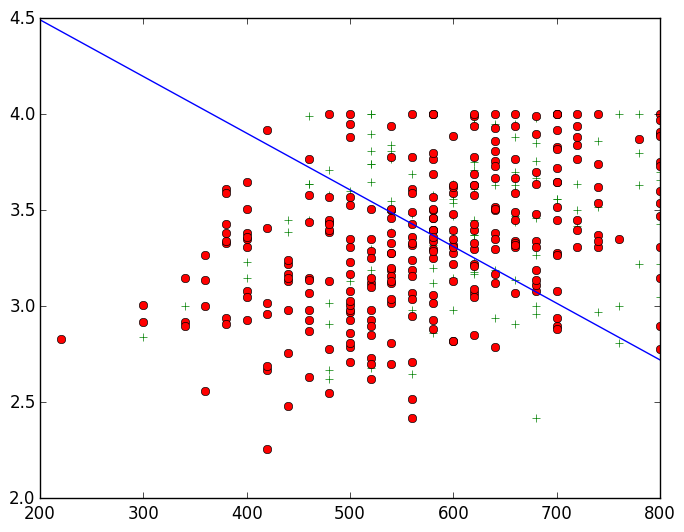

3-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3A9934F0>
 PyObject <matplotlib.lines.Line2D object at 0x3A993650>
 PyObject <matplotlib.lines.Line2D object at 0x3A993990>

In [13]:
# Regression against Data
yes=[transpose(zeros(4))];
no=[transpose(zeros(4))];
for i = 1:m
    if y[i]==1
        yes = [yes; u[i,:]];
    end
    if y[i] == 0
        no = [no; u[i,:]];
    end
end
ym = size(yes,1)
nm = size(no,1)
gre=200:600/300:800
gpa=2.2:1.8/300:4.0
plot(yes[2:end,1],yes[2:end,2],"g+", no[2:end,1],no[2:end,2],"ro",gre,((1/2) - a[1]*gre - a[4])/a[2])